In [430]:
suppressPackageStartupMessages({
    library(RhpcBLASctl, quietly = T)
    
    library(splatter, quietly = T)
    
    library(scater, quietly = T)
    library(scran, quietly = T)
    library(bluster, quietly = T)
    
    library(BBmisc, quietly = T)
    
    library(liana, quietly = T)
    
    library(aricode, quietly = T)
    library(kBET, quietly = T)
    
    library(zellkonverter, quietly = T)
    
    library(reticulate, quietly = T)
    scanorama <- import('scanorama')
    scvi <- import("scvi", convert = FALSE)
})

source('./simulation_functions.r')

seed = 888
set.seed(seed)
data.path<-'/data3/hratch/ccc_protocols/'
n.cores<-20
RhpcBLASctl::blas_set_num_threads(n.cores)

ERROR: Error in registerDoMC(cores = n.cores): could not find function "registerDoMC"


# Functions

In [ ]:
add.context.noise<-function(sim, context.noise, contexts){
    colData(sim)[['Context']]<-NULL
    for (i in seq_along(contexts)){
        context.cells<-contexts[[i]]
        noise.sim<-context.noise[[i]]

        counts(sim)[, context.cells] <- as.matrix(counts(sim)[, context.cells] + counts(noise.sim))
        colData(sim)[context.cells, 'Context']<-paste0('Context_', i)
    }
    return(sim)
}

scanorama.batch.correct<-function(sce.batch){

    # prep scanorama inputs - split expression objects by batch
    batches<-list()
    genes<-list()
    for (batch in unique(colData(sce.batch)$Batch)){
        cells.in.batch<-rownames(colData(sce.batch)[colData(sce.batch)$Batch == batch,])
        sce.singlebatch<-sce.batch[, cells.in.batch]

        batches[[batch]]<-t(assays(sce.singlebatch)$logcounts) # cells x genes
        genes[[batch]]<-as.list(rownames(sce.batch))
    }

    # do the batch correction 
    corrected.data <- scanorama$correct(unname(batches), unname(genes), return_dense=TRUE)

    # format into the sce
    genes<-corrected.data[[2]]
    corrected.data<-corrected.data[[1]]

    for (i in 1:length(corrected.data)){
        expr<-corrected.data[[i]]
        colnames(expr) <- genes
        rownames(expr) <- rownames(batches[[i]])
        corrected.data[[i]] <- t(expr)
    }
    corrected.data <- do.call(cbind, corrected.data)

    if (!identical(dim(corrected.data), dim(assays(sce.batch)$logcounts))){ # sanity check
        stop('Unexpected filters in scanorama batch correction')
    }
    corrected.data<-corrected.data[rownames(assays(sce.batch)$logcounts), colnames(assays(sce.batch)$logcounts)]
    assays(sce.batch)[['batch.corrected.counts']] <- corrected.data
    
    return(sce.batch)
}

scvi.batch.correct<-function(sce.batch, seed = 888){
    
    scvi$settings$seed = as.integer(seed)
    scvi$settings$num_threads = as.integer(1)
    scvi$settings$dl_num_workers = as.integer(n.cores)

    adata.batch<-zellkonverter::SCE2AnnData(sce.batch, X_name = 'counts') # adata with raw UMI counts as main
    reticulate::py_set_seed(seed)
    scvi$model$SCVI$setup_anndata(adata.batch, layer = 'TrueCounts', batch_key = 'Batch')
    model = scvi$model$SCVI(adata.batch, n_layers = 2L, n_latent = 30L, gene_likelihood= "nb") # non-default args - 
    model$train()

    # library size and log1p make it similar to log(1+CPM) normalization, but with batch correction
    # batch corrected counts: https://discourse.scverse.org/t/how-to-extract-batch-corrected-expression-matrix-from-trained-scvi-vae-model/151
    corrected.data = model$get_normalized_expression(transform_batch = sort(unique(colData(sce.batch)$Batch)),
                                                    library_size = 1e6)
    corrected.data<-t(log1p(reticulate::py_to_r(corrected.data)))

    if (!identical(dim(corrected.data), dim(assays(sce.batch)$logcounts))){ # sanity check
            stop('Unexpected filters in scvi batch correction')
        }
    
    assays(sce.batch)[['batch.corrected.counts']] <- corrected.data
    return(sce.batch)
    
}

do.batch.correction<-function(sce.batch){
    sce.scanorama<-scanorama.batch.correct(sce.batch)
    sce.scvi<-scvi.batch.correct(sce.batch)
    sce.batches<-list(sim.scanorama = sce.scanorama, sim.scvi = sce.scvi)
    return(sce.batches)
}

search.clusters<-function(sce, n.cell.types, iter.limit = 20){
    res.param<-1
    clusters<-scran::clusterCells(sce, use.dimred="PCA", 
                        BLUSPARAM=NNGraphParam(shared = T, cluster.fun="louvain", 
                                              cluster.args=list(resolution=res.param))) 
    n.clusters<-length(unique(clusters))
    
    iter <- 1
    while (n.clusters != n.cell.types){
        if (n.clusters < n.cell.types){
            res.param = res.param*2
            clusters<-scran::clusterCells(sce, use.dimred="PCA", 
                        BLUSPARAM=NNGraphParam(shared = T, cluster.fun="louvain", 
                                              cluster.args=list(resolution=res.param)))
            n.clusters<-length(unique(clusters))
        }
        else{
            res.param = res.param/10
            clusters<-scran::clusterCells(sce, use.dimred="PCA", 
                        BLUSPARAM=NNGraphParam(shared = T, cluster.fun="louvain", 
                                              cluster.args=list(resolution=res.param)))
            n.clusters<-length(unique(clusters))

        }
        if (iter > iter.limit){stop('Too many iterations when searching for cluster resolution')}
        iter<-iter + 1
    }
    return(clusters)
}

cluster.cells<-function(sce, assay.type, n.cell.types){
    sce <- scran::fixedPCA(sce, assay.type = assay.type, subset.row=NULL) # default 50 PCs
    # clustering http://bioconductor.org/books/3.13/OSCA.basic/clustering.html
    colData(sce)[['Cluster']]<-search.clusters(sce, n.cell.types)
    return(sce)
}

quantify.batch.effect<-function(sce, assay.type){
    nmi<-aricode::NMI(colData(sce)$Group, colData(sce)$Cluster) # clusterability
    kbet<-kBET(df = t(assays(sce)[[assay.type]]), batch = colData(sce)$Batch, # mixability
                        plot = F)$summary['mean', 'kBET.observed']
    # sil.cluster <- as.data.frame(silhouette(as.numeric(colData(sce)$Cluster), 
    #                               dist(reducedDims(sce)$PCA)))
    # sil.cluster<-mean(aggregate(sil.cluster[, 'sil_width'], list(sil.cluster$cluster), mean)$x)
    
    return(list(clusterability = 1 - nmi, mixability = kbet))
}


count.negative<-function(df){
    return(length(df[df<0])/length(df))
}
# only have the from and to assay params because 
# liana errors out if setting assay.type = batch.corrected.counts
# so this is a hacky way around that
replace.negative.counts<-function(sce, fill_val = 0, 
                                  from_assay = 'batch.corrected.counts', 
                                 to_assay = 'logcounts'){
    df<-assays(sce)[[from_assay]]
    df[df<0]<-fill_val
    assays(sce)[[to_assay]]<-df  
    return(sce)
}

# Baseline

## Baseline parameters

In [4]:
base_params <- newSplatParams()
n.cells<-5e3
n.cell.types<-6
n.genes<-2e3
n.lrs<-2e2
n.contexts<-5

n.batches<-1 

baseline_params <- setParams(
    base_params,
    seed = seed,
    nGenes = n.genes,
    
    # batches - introduce mild ones to have context-driven changes since will treat batch as context
    batchCells = rep(n.cells/n.batches, n.batches),
    batch.rmEffect = TRUE, 
    batch.facLoc = 0, # higher values increase batch severity
    batch.facScale = 0, # higher values increase batch severity
    # cell types
    group.prob = rep(1/n.cell.types, n.cell.types), 
    de.facLoc = 0.65, # increase separation between cell types
    de.facScale = 0.1 # increase separation between cell types
)

## Context-specific effects

First, we will create a dataset with no batch effects and all the cell types well separated: 

In [209]:
sim.baseline<-splatSimulateGroups(baseline_params, verbose = F)

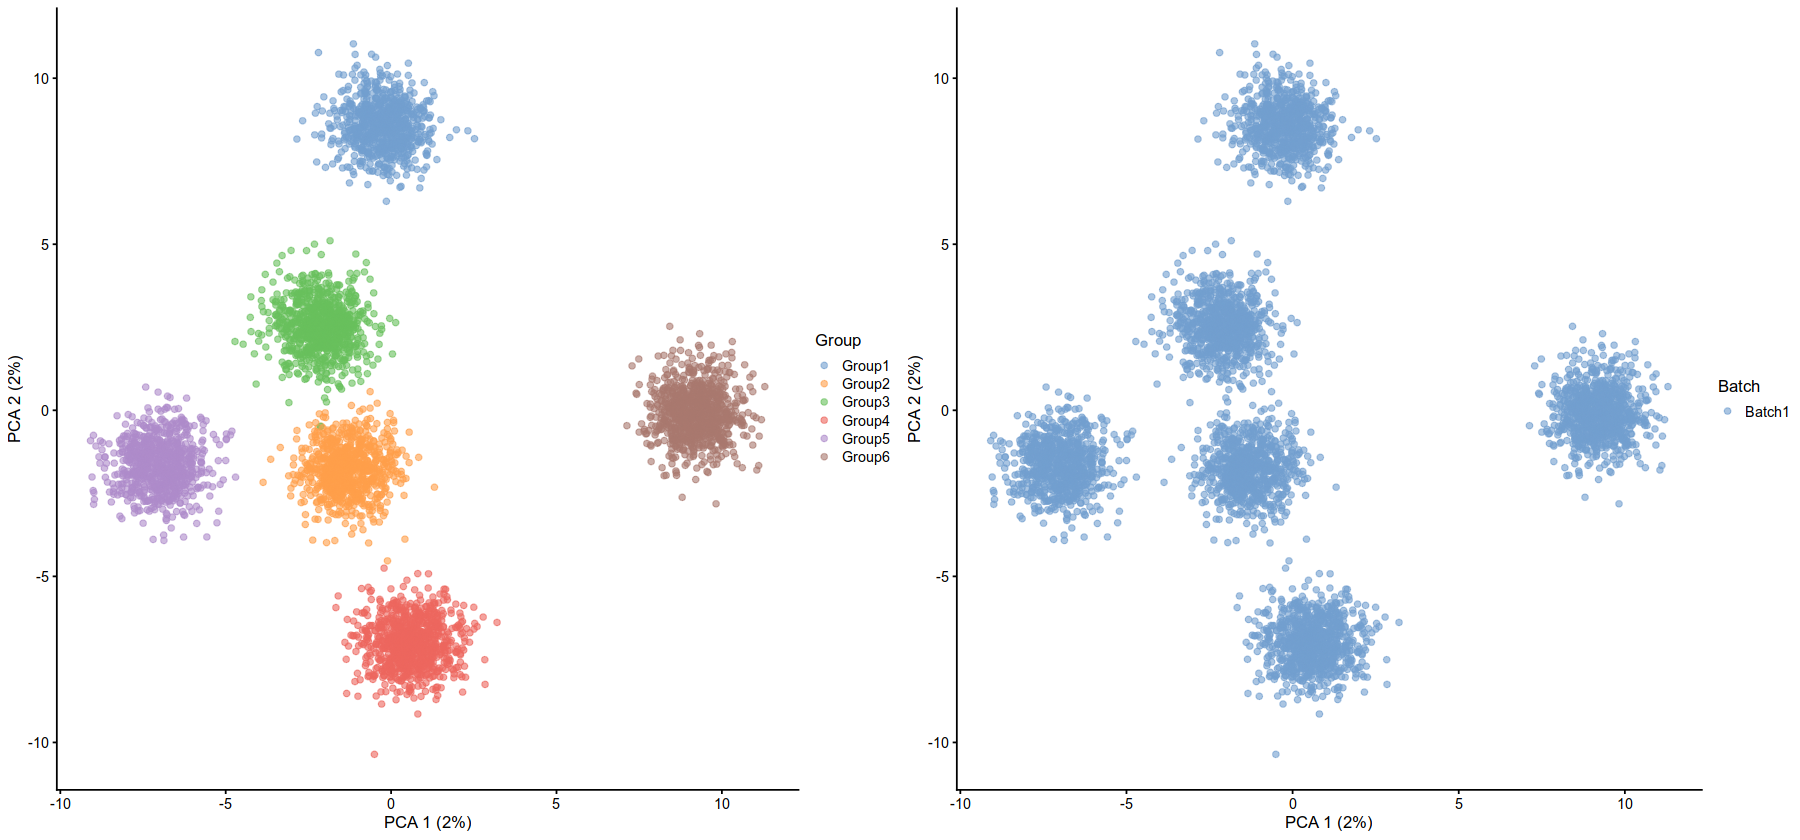

In [210]:
sim.baseline.viz<-sim.baseline

sim.baseline.viz <- qc.data(sim.baseline.viz)
sim.baseline.viz <- scater::logNormCounts(sim.baseline.viz)
sim.baseline.viz <- scran::fixedPCA(sim.baseline.viz, assay.type = 'logcounts', subset.row=NULL) # default 50 PCs

h_ = 7
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

g1a<-plotPCA(sim.baseline.viz, colour_by = "Group")
g1b<-plotPCA(sim.baseline.viz, colour_by = "Batch")

g1<-ggpubr::ggarrange(g1a, g1b, ncol = 2)
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data.path, 'figures/', 'batch_effect_baseline', ext), g1, 
                                             height = h_, width = w_)}
g1

Next, we add some context-specific noise to create a tensor that will have multiple factors. 

This context-specific noise will be added to each simulation (need to double check that the cell groups are consistently split the same for this).

In [211]:
set.seed(seed)
contexts <- BBmisc::chunk(colnames(sim.baseline),
                                    chunk.size = n.cells/n.contexts,
                                    shuffle = TRUE)

context.noise<-list()
for (i in seq_along(contexts)){
    context.cells<-contexts[[i]]
    
    noise.sim <- splatSimulate(
                nGenes = n.genes,
                batchCells = length(context.cells),
                lib.loc    = 6,
                lib.scale  = 0.6,
                verbose    = FALSE,
                seed       = seed+i
            )
    context.noise[[i]]<-noise.sim
}
sim.baseline.context<-add.context.noise(sim.baseline, context.noise, contexts)

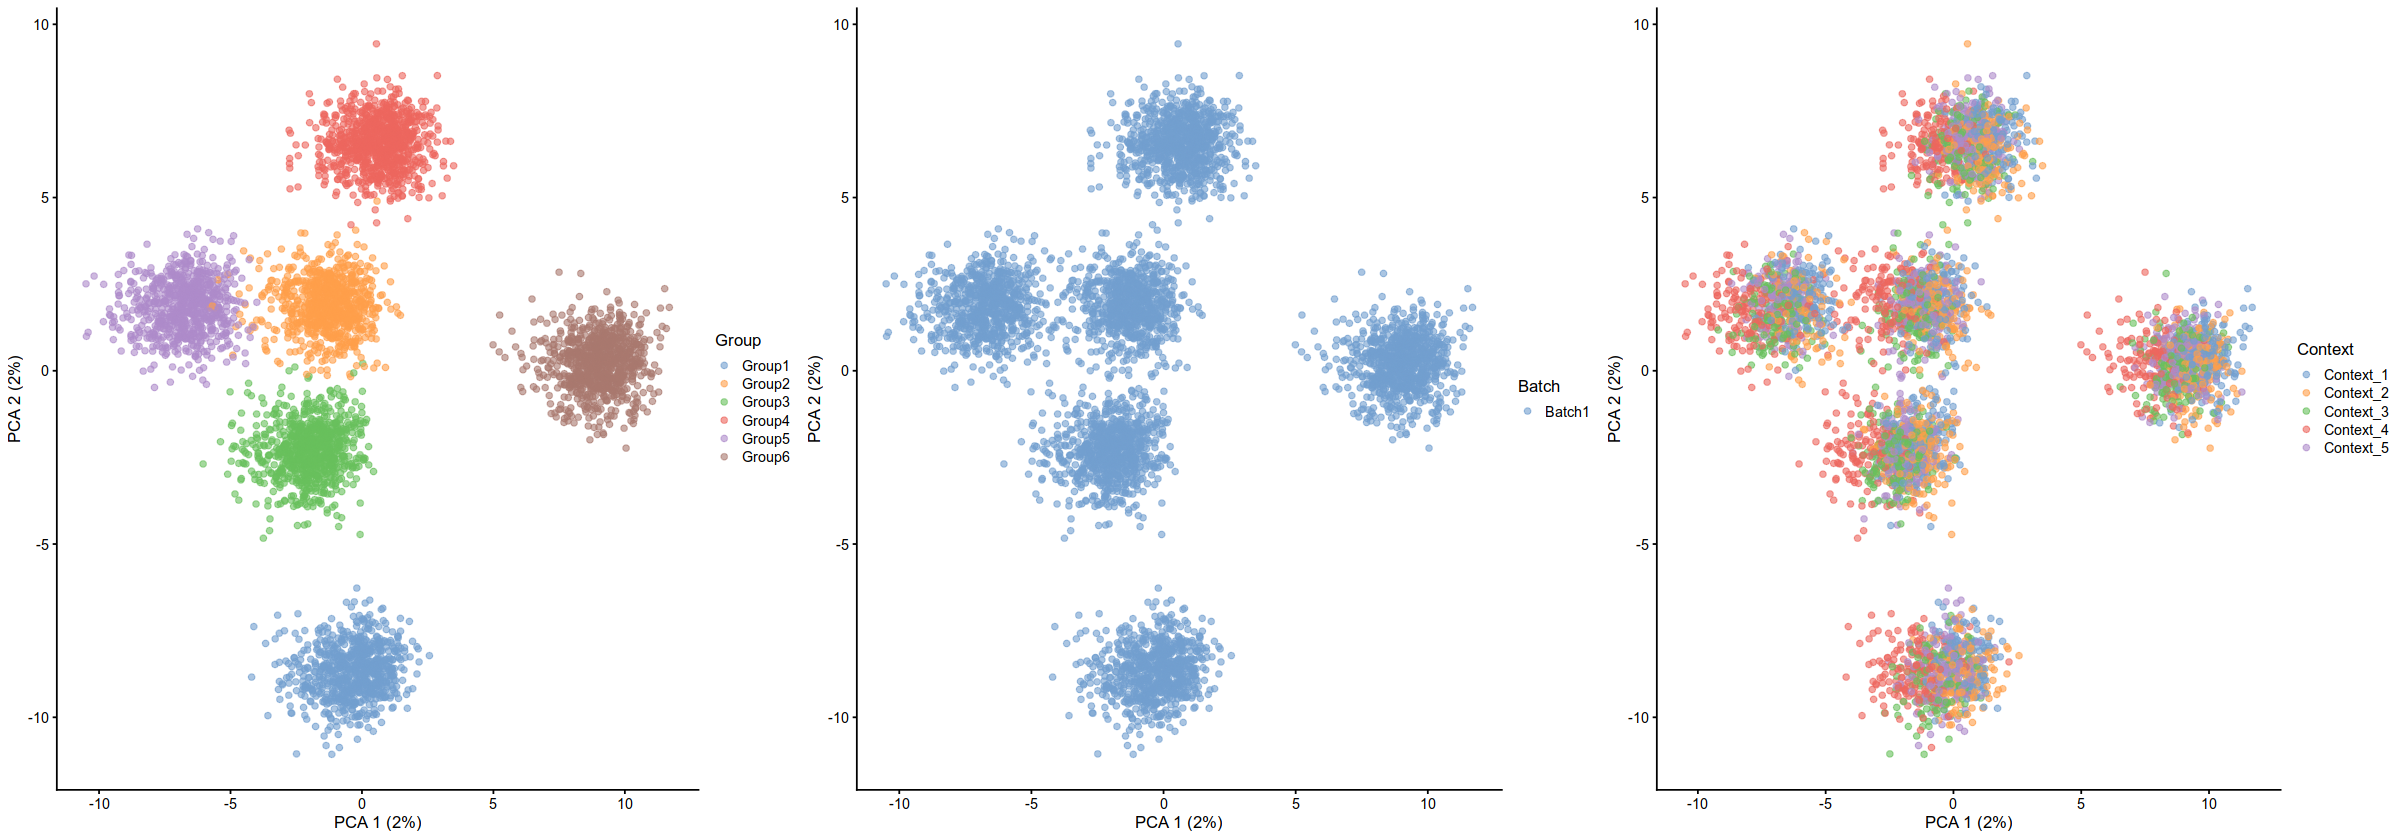

In [212]:
sim.viz<-sim.baseline.context
sim.viz<-qc.data(sim.viz)
sim.viz <- scater::logNormCounts(sim.viz)
sim.viz <- scran::fixedPCA(sim.viz, assay.type = 'logcounts', subset.row=NULL) # default 50 PCs

h_ = 7
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)

g2a<-plotPCA(sim.viz, colour_by = "Group")
g2b<-plotPCA(sim.viz, colour_by = "Batch")
g2c<-plotPCA(sim.viz, colour_by = "Context")


g2<-ggpubr::ggarrange(g2a, g2b, g2c, ncol = 3)
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data.path, 'figures/', 'batch_effect_baseline_context', ext), g2, 
                                             height = h_, width = w_)}
g2

In [213]:
df<-data.frame(colData(sim.baseline.context))
cell.counts<-ddply(df, .(df$Context, df$Group), nrow)
reshape2::dcast(df, Context ~ Group)

Using Context as value column: use value.var to override.

Aggregation function missing: defaulting to length



Context   Group1 Group2 Group3 Group4 Group5 Group6
1 Context_1 153    152    171    174    169    181   
2 Context_2 157    161    184    181    136    181   
3 Context_3 147    151    195    166    165    176   
4 Context_4 180    170    143    181    165    161   
5 Context_5 166    161    160    191    148    174

## LR simulation

In [10]:
# generate a LR PPI on a subset of the genes
set.seed(seed)
lr.genes<-sort(as.character(sample(rownames(sim.baseline.context), size = n.lrs, replace = FALSE)))
lr.ppi<-generate.lr.ppi(lr.genes)
interacting.lr.genes<-unique(c(lr.ppi$source_genesymbol, lr.ppi$target_genesymbol))

## Expected Tensor Rank

In [33]:
sim.baseline.context.list<-split.by.context(sim.baseline.context, context_lab = 'Context') 

# log-normalize
sim.baseline.context.list<-lapply(sim.baseline.context.list, FUN = function(sce) {
    sce <- scater::logNormCounts(sce)
})

# calculate communication scores
scores.baseline.context<-score.communication(sim.baseline.context.list, lr.ppi)

# build and decompose tensor
tensor.baseline.context<-list()
for (score.type in names(scores.baseline.context)){
    tensor.baseline.context[[score.type]]<-liana_tensor_c2c(context_df_dict = scores.baseline.context[[score.type]],
                                       score_col = 'score',
                                       ligand_col = 'ligand', 
                                       receptor_col = 'receptor', 
                                       lr_fill = NaN, 
                                       cell_fill = NaN,
                                       how = 'outer',
                                       seed = 888, 
                                       conda_env = env.name,
                                       build_only = F)

    
}

for (score.type in names(tensor.baseline.context)){
    print(paste0('The rank with context-effects using ', score.type, ' is ', tensor.baseline.context[[score.type]]$rank))
}

[1] "The rank with context-effects using natmi is 3"
[1] "The rank with context-effects using sca is 4"


### Visualize decomposition

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 5 rows [1, 2, 3, 4, 5].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 5 rows [1, 2, 3, 4, 5].”


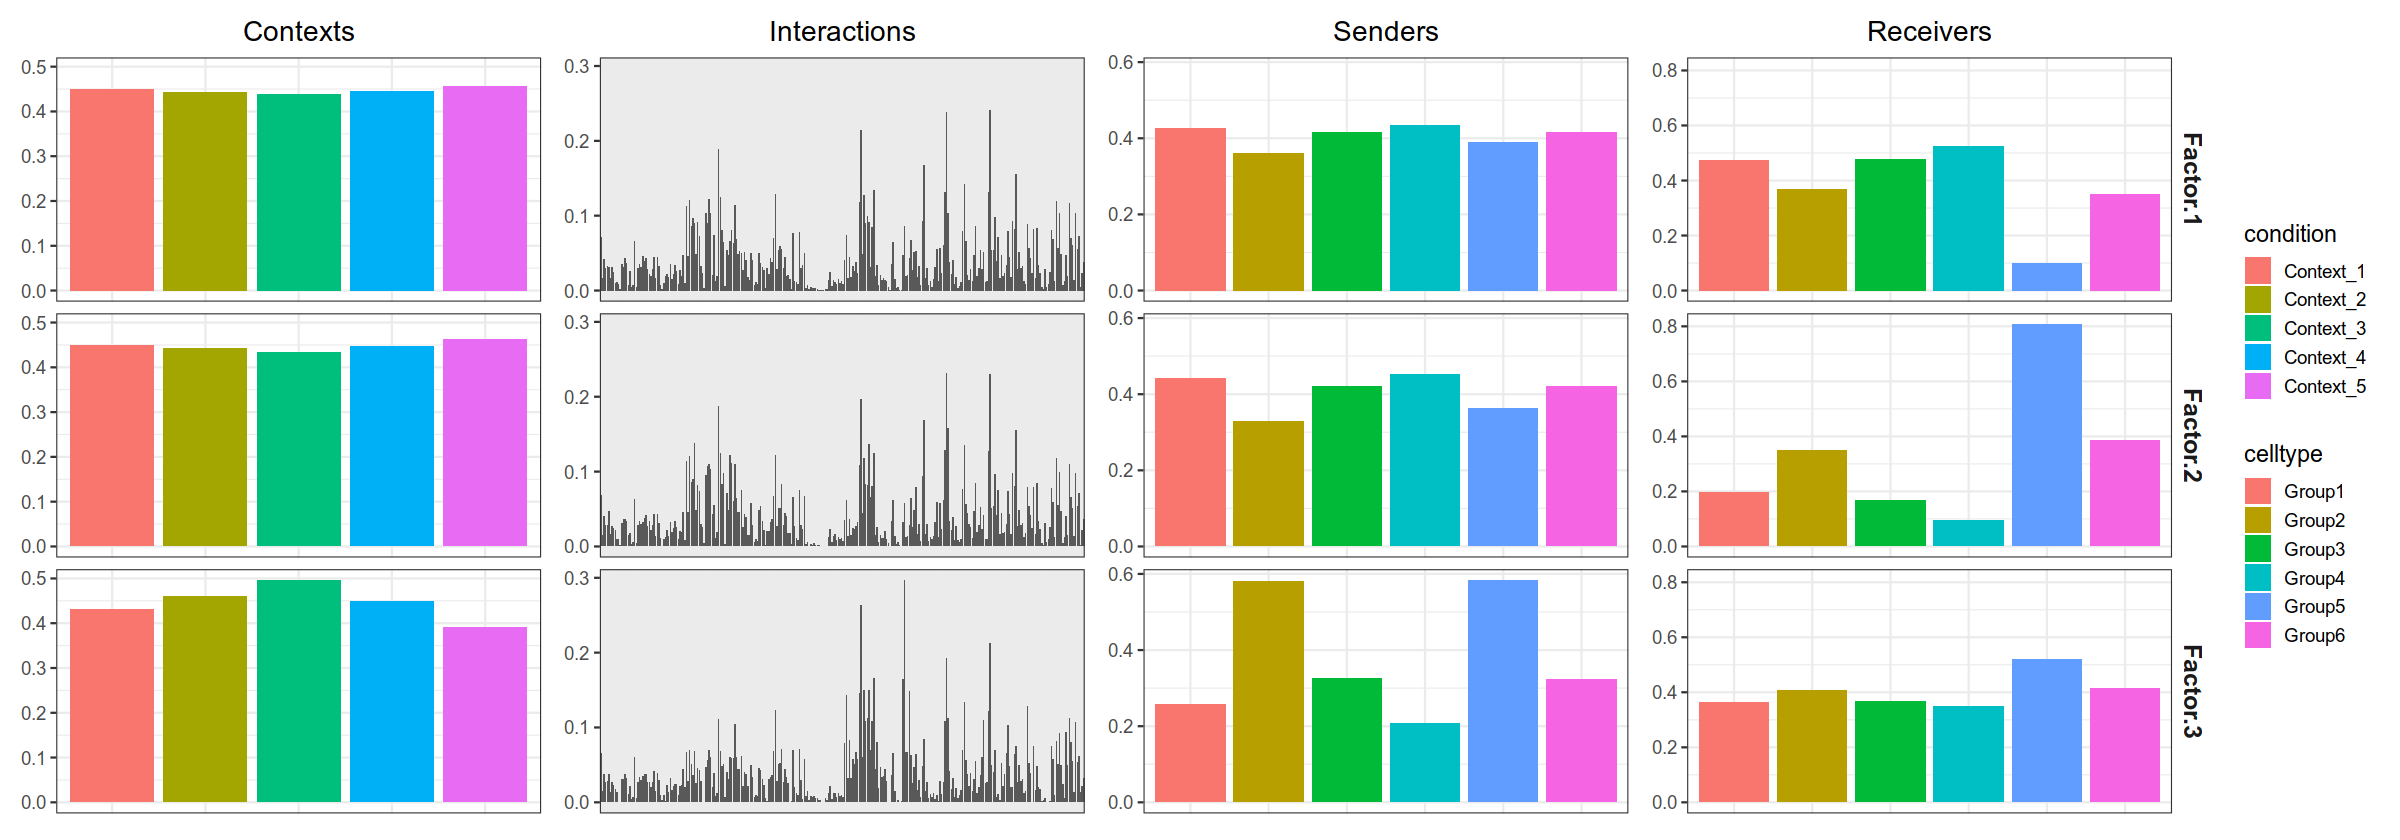

In [689]:
suppressMessages({
    natmi.factors <- format_c2c_factors(tensor.baseline.context$natmi$factors)
    sca.factors <- format_c2c_factors(tensor.baseline.context$sca$factors)
})

plot_c2c_overview(natmi.factors)

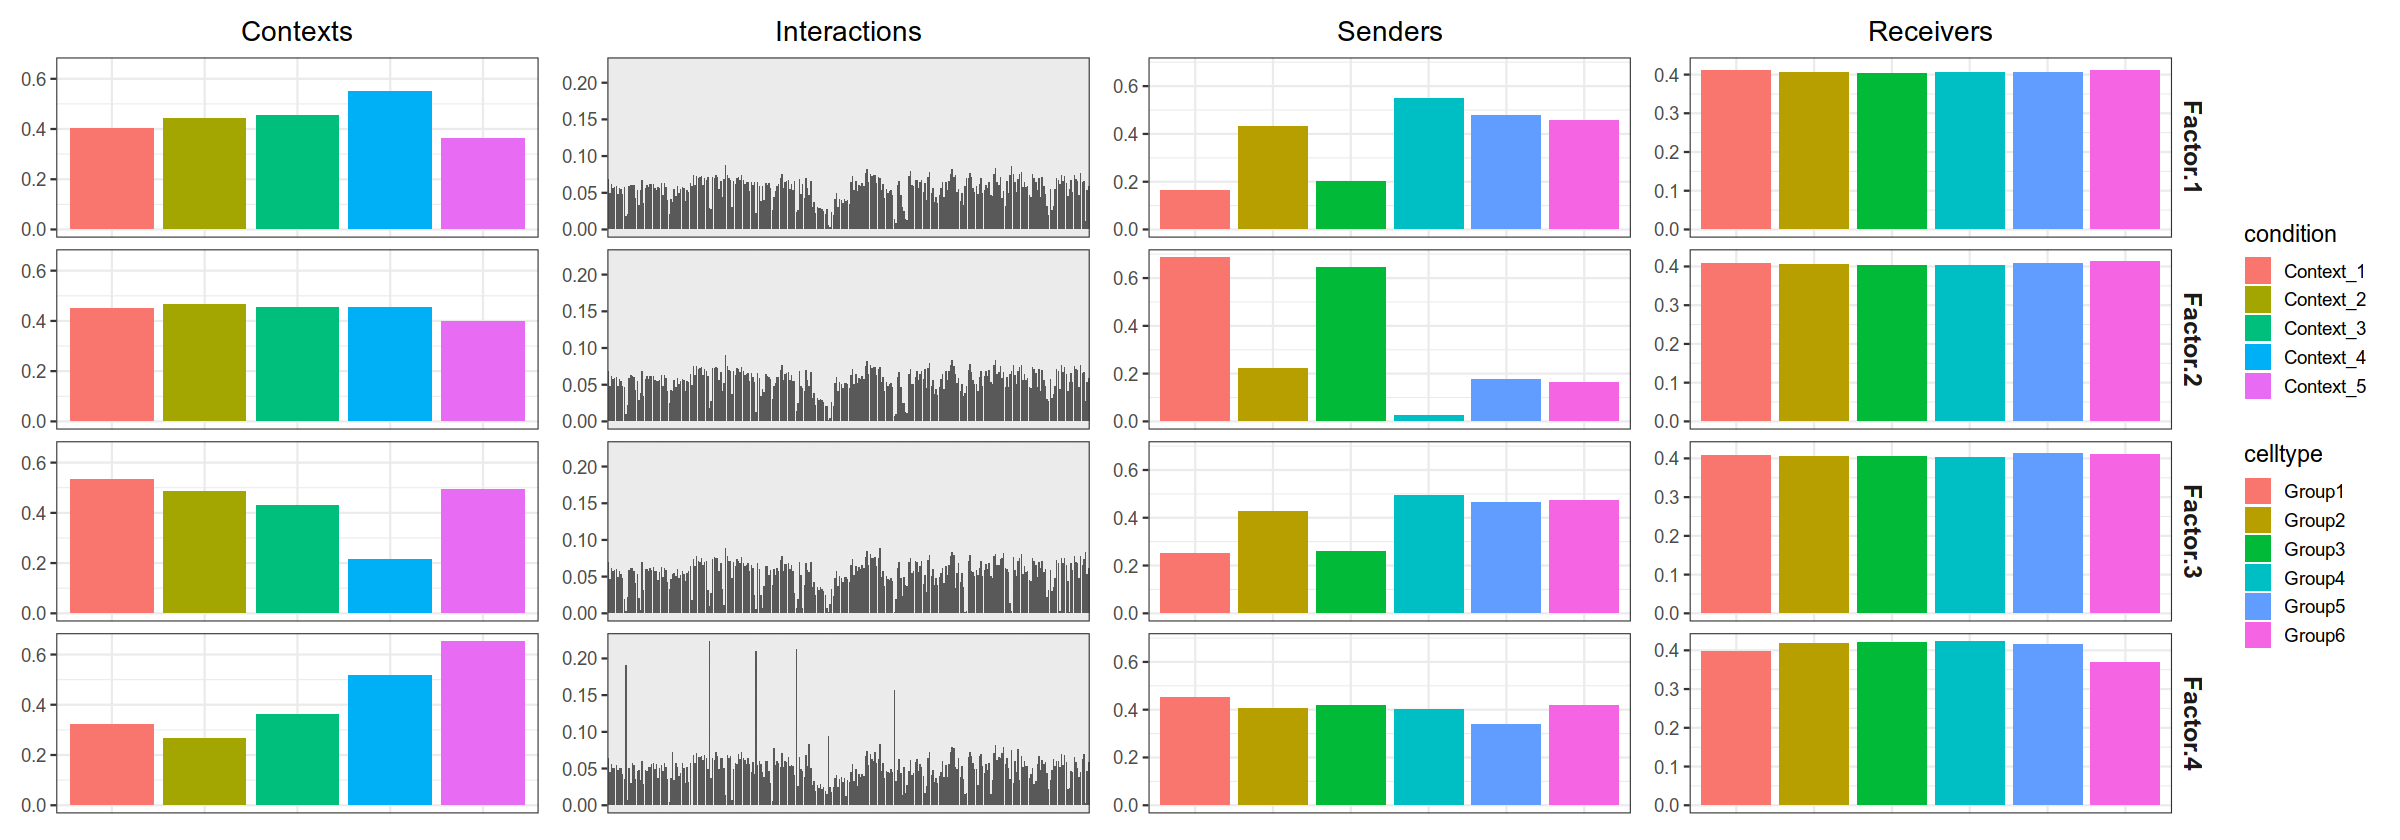

In [690]:
plot_c2c_overview(sca.factors)

# Example of an iteration

Here is what the baseline params with an actual batch effect simulation looks like:

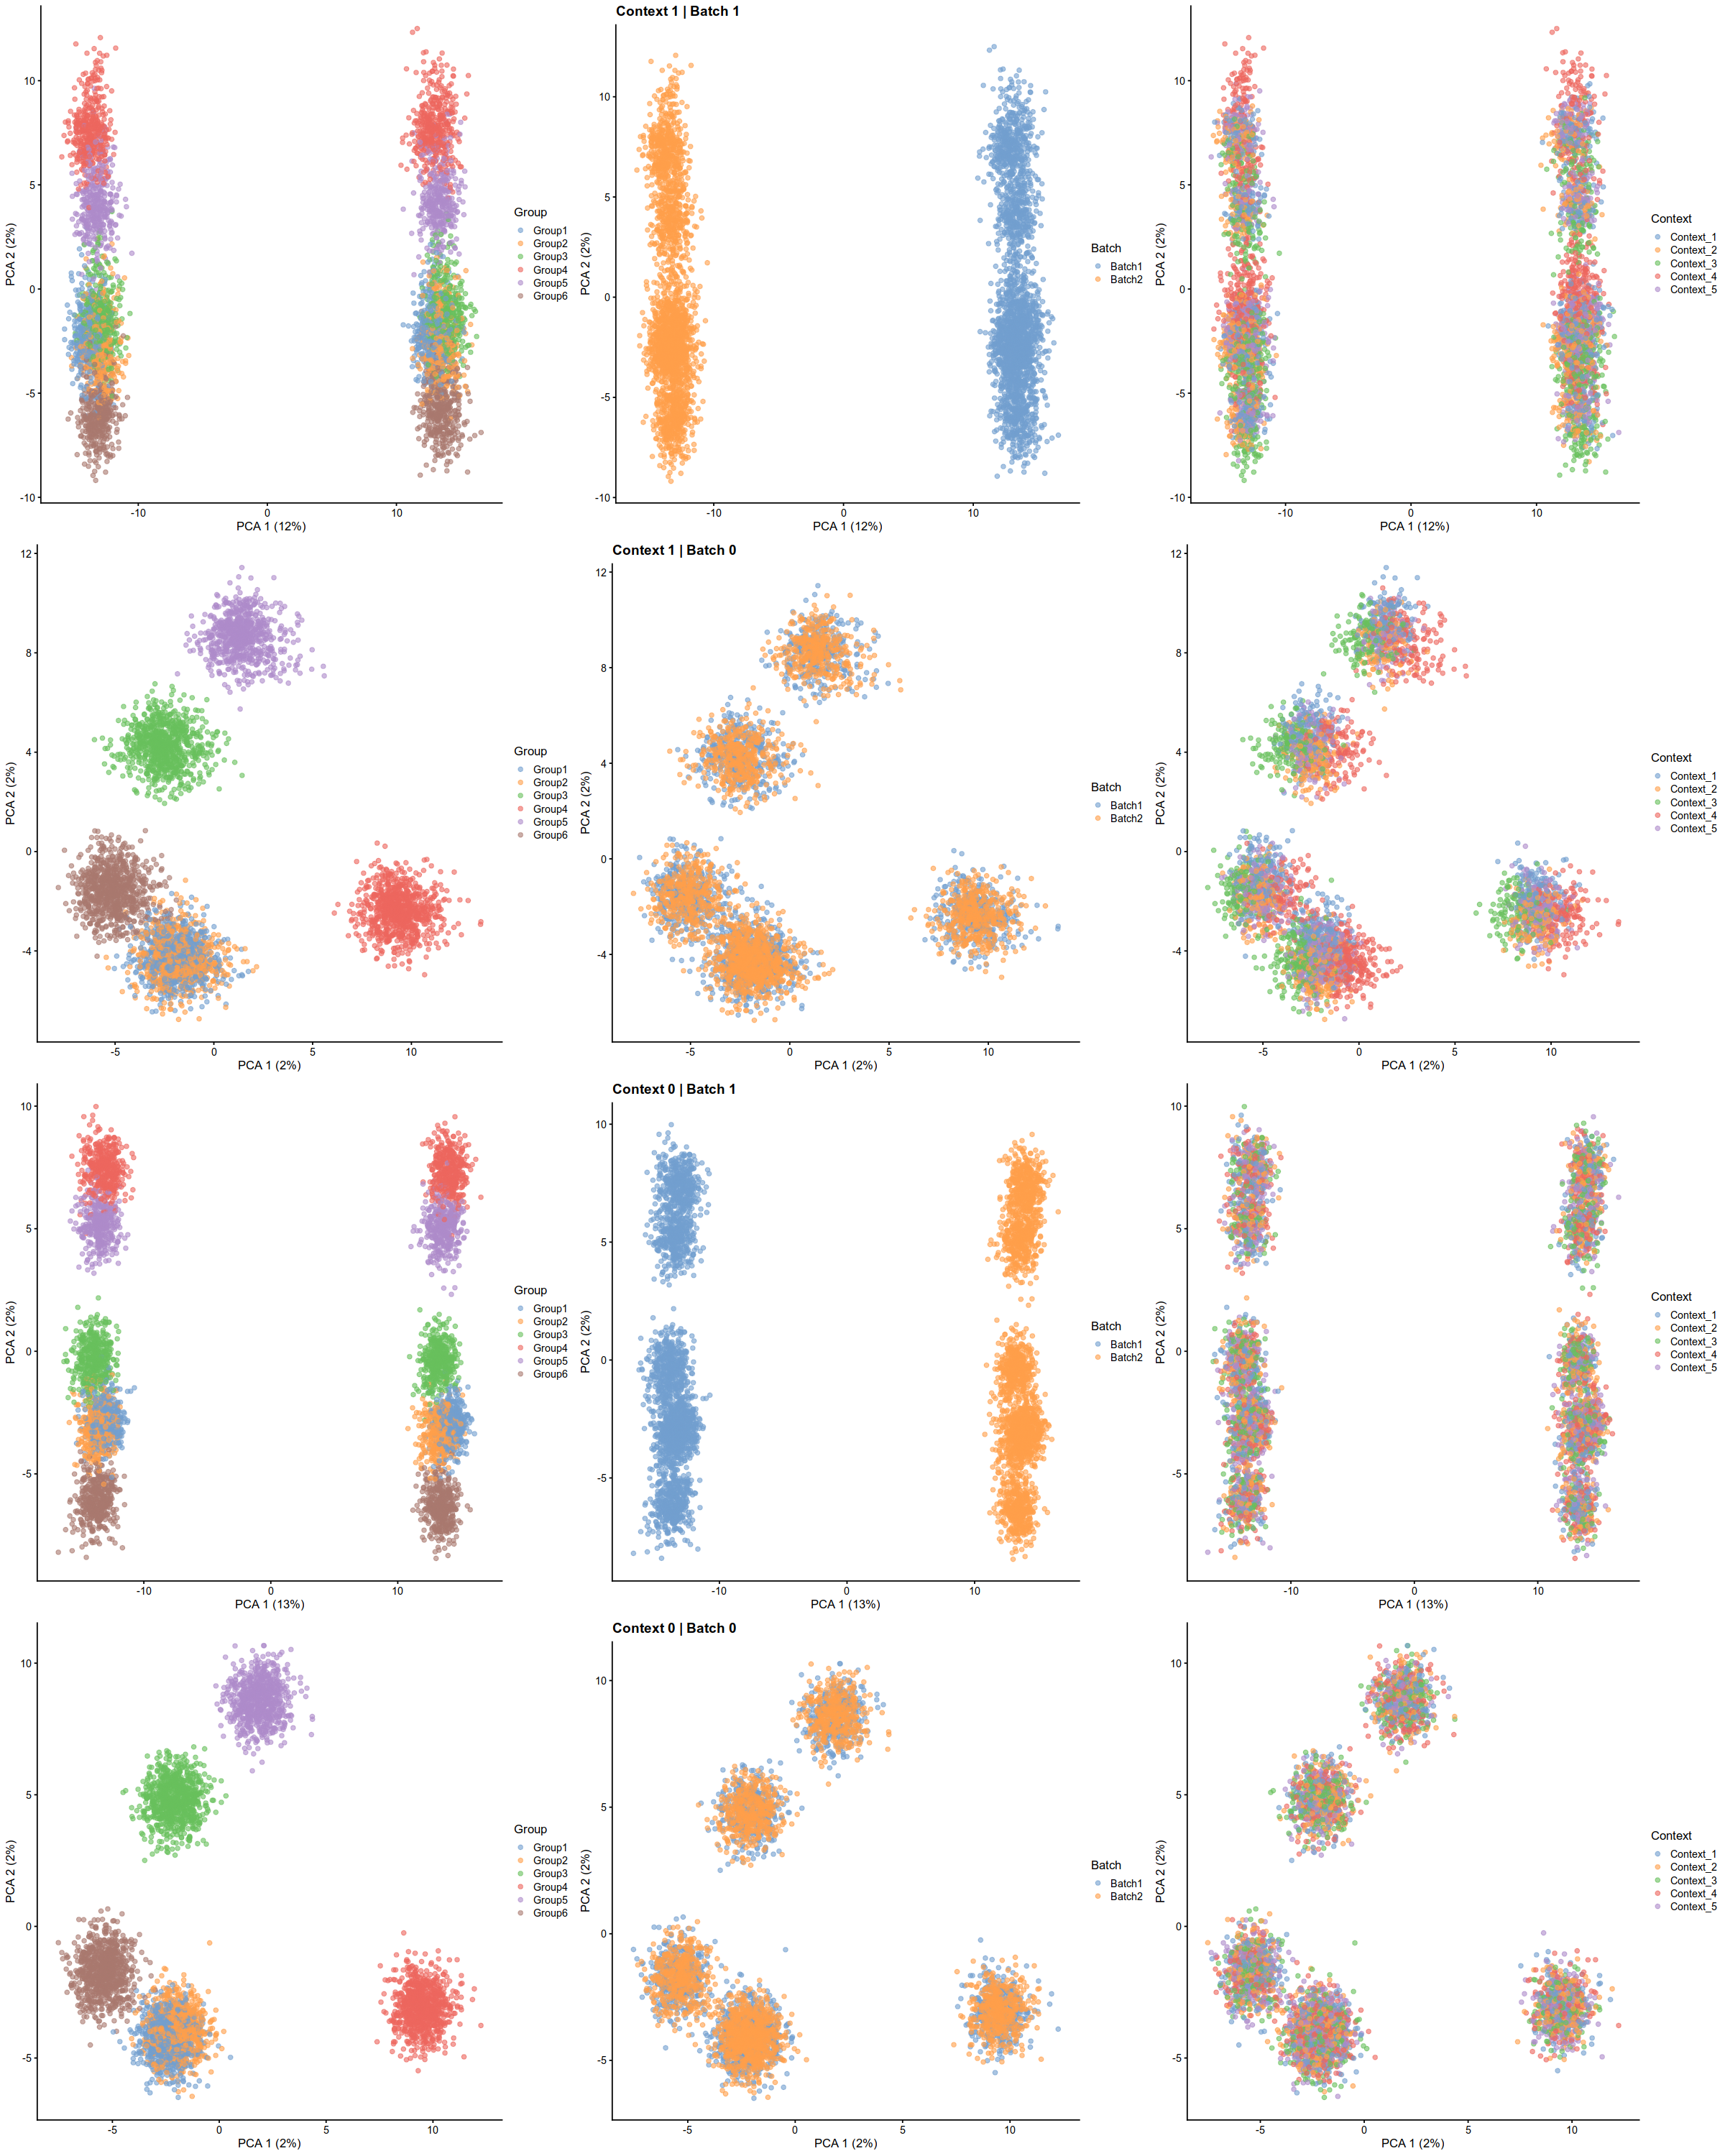

In [134]:
iter.params.list = list()
iter.params.list[[1]] = list(n.batches = 2, batch.scale = 0.25, batch.location = 0.25)
iter.params<-iter.params.list[[1]]

sim_params <- setParams(
    baseline_params,
    
    # batches
    batchCells = rep(n.cells/iter.params$n.batches, iter.params$n.batches),
    batch.facLoc = iter.params$batch.location, # higher values increase batch severity
    batch.facScale = iter.params$batch.scale, # higher values increase batch severity
    batch.rmEffect = FALSE, # create the gold standard when set to True

)

sim<-splatSimulateGroups(sim_params, verbose = F)
sim.gold<-splatSimulateGroups(sim_params, verbose = F, batch.rmEffect = T)
sim.gold<-splatSimulateGroups(sim_params, verbose = F, batch.rmEffect = T)
expr.datasets<-list(sim.gold = sim.gold, sim.log = sim)

expr.datasets.nc<-expr.datasets
expr.datasets<-lapply(expr.datasets, FUN = function(sce) add.context.noise(sce, context.noise, contexts))
                      
expr.datasets<-lapply(expr.datasets, FUN = function(sce) qc.data(sce))
expr.datasets.nc<-lapply(expr.datasets.nc, FUN = function(sce) qc.data(sce))
                         
expr.datasets<-lapply(expr.datasets, FUN = function(sce) scater::logNormCounts(sce))
expr.datasets.nc<-lapply(expr.datasets.nc, FUN = function(sce) scater::logNormCounts(sce))
                         
expr.datasets<-lapply(expr.datasets, FUN = function(sce) scran::fixedPCA(sce, assay.type = 'logcounts', subset.row=NULL))
expr.datasets.nc<-lapply(expr.datasets.nc, FUN = function(sce) scran::fixedPCA(sce, assay.type = 'logcounts', subset.row=NULL))

                         
intersect.cells<-Reduce(intersect, list(colnames(expr.datasets$sim.log), colnames(expr.datasets$sim.gold), 
                       colnames(expr.datasets.nc$sim.log), colnames(expr.datasets.nc$sim.gold)))
expr.datasets<-lapply(expr.datasets, FUN = function(sce) sce[, intersect.cells])
expr.datasets.nc<-lapply(expr.datasets.nc, FUN = function(sce) sce[, intersect.cells])
                         
for (i in seq_along(expr.datasets.nc)){
    sce<-expr.datasets.nc[[i]]
    colData(sce)[['Context']] = colData(expr.datasets$sim.log)$Context
    expr.datasets.nc[[i]]<-sce
}

h_ = 25
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)

g1a<-plotPCA(expr.datasets$sim.log, colour_by = "Group")
g1b<-plotPCA(expr.datasets$sim.log, colour_by = "Batch") + ggtitle('Context 1 | Batch 1')
g1c<-plotPCA(expr.datasets$sim.log, colour_by = "Context")
g1<-ggpubr::ggarrange(g1a, g1b, g1c, ncol = 3)

g2a<-plotPCA(expr.datasets$sim.gold, colour_by = "Group")
g2b<-plotPCA(expr.datasets$sim.gold, colour_by = "Batch") + ggtitle('Context 1 | Batch 0')
g2c<-plotPCA(expr.datasets$sim.gold, colour_by = "Context")
g2<-ggpubr::ggarrange(g2a, g2b, g2c, ncol = 3) 

g3a<-plotPCA(expr.datasets.nc$sim.log, colour_by = "Group")
g3b<-plotPCA(expr.datasets.nc$sim.log, colour_by = "Batch") + ggtitle('Context 0 | Batch 1')
g3c<-plotPCA(expr.datasets.nc$sim.log, colour_by = "Context")
g3<-ggpubr::ggarrange(g3a, g3b, g3c, ncol = 3)

g4a<-plotPCA(expr.datasets.nc$sim.gold, colour_by = "Group")
g4b<-plotPCA(expr.datasets.nc$sim.gold, colour_by = "Batch") + ggtitle('Context 0 | Batch 0')
g4c<-plotPCA(expr.datasets.nc$sim.gold, colour_by = "Context")
g4<-ggpubr::ggarrange(g4a, g4b, g4c, ncol = 3) 

g4<-ggpubr::ggarrange(g1,g2,g3,g4, ncol = 1) 
g4

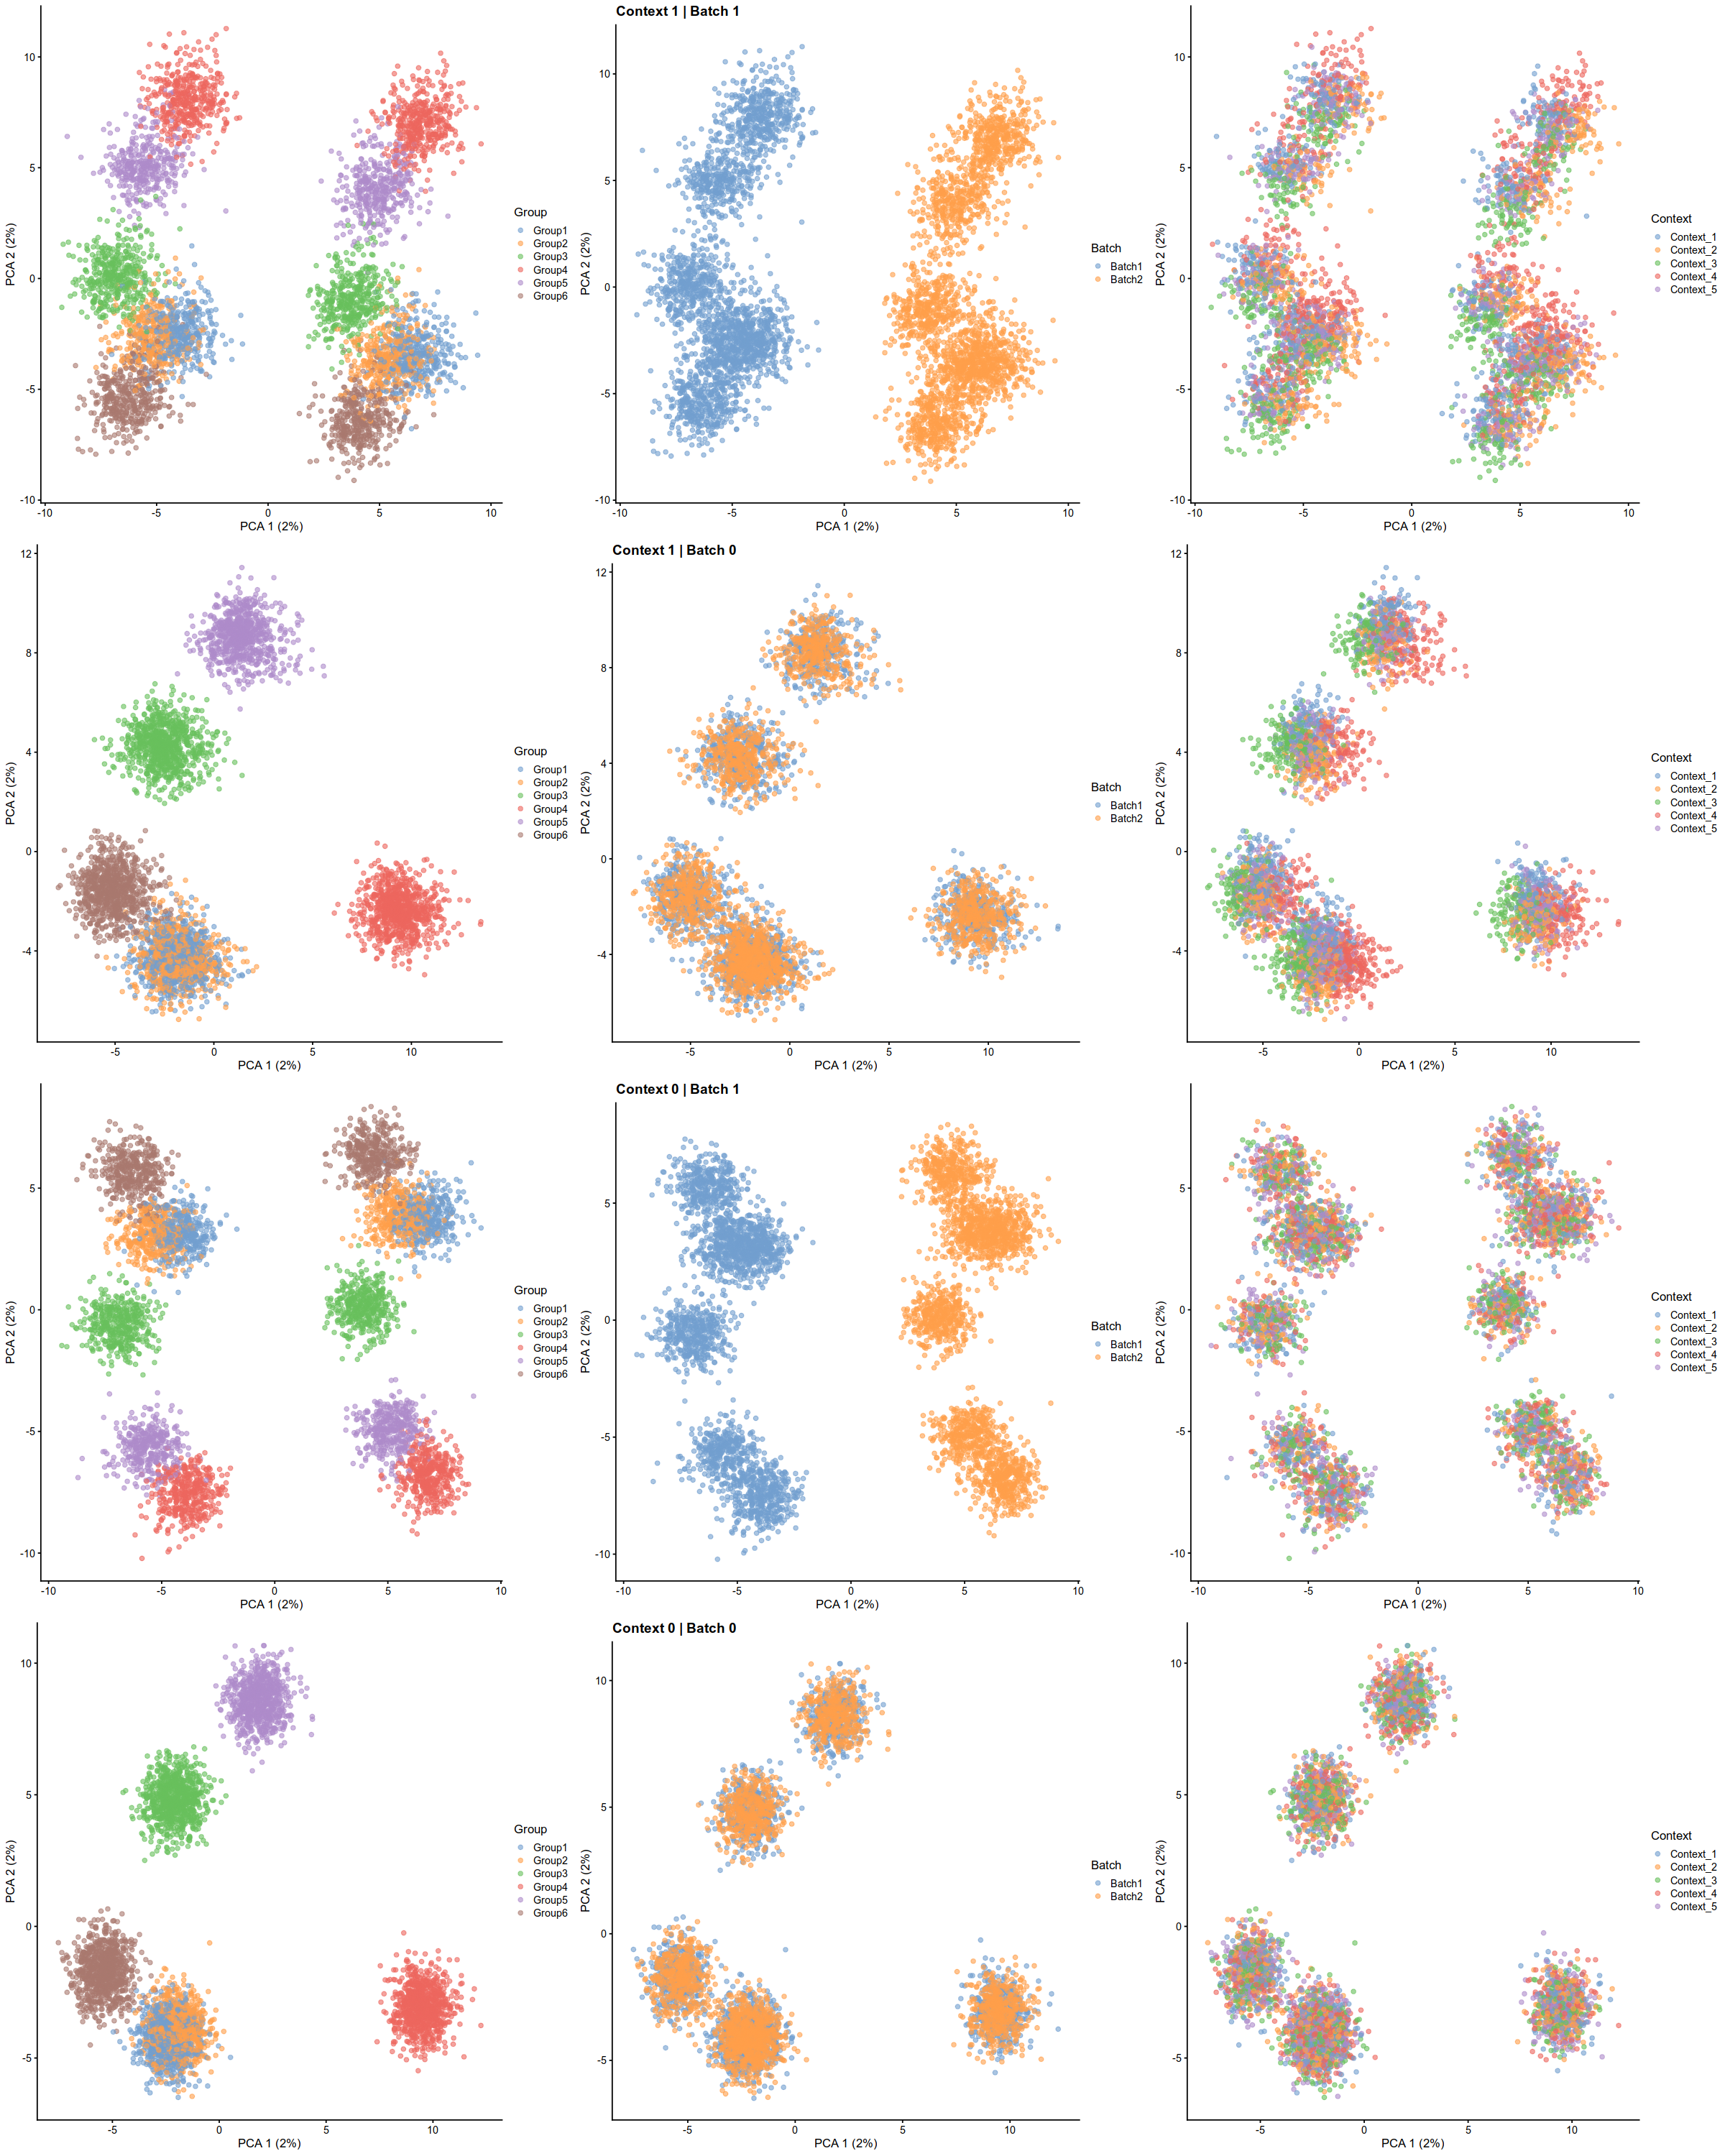

In [135]:
iter.params.list = list()
iter.params.list[[1]] = list(n.batches = 2, batch.scale = 0.1, batch.location = 0.1)
iter.params<-iter.params.list[[1]]

sim_params <- setParams(
    baseline_params,
    
    # batches
    batchCells = rep(n.cells/iter.params$n.batches, iter.params$n.batches),
    batch.facLoc = iter.params$batch.location, # higher values increase batch severity
    batch.facScale = iter.params$batch.scale, # higher values increase batch severity
    batch.rmEffect = FALSE, # create the gold standard when set to True

)

sim<-splatSimulateGroups(sim_params, verbose = F)
sim.gold<-splatSimulateGroups(sim_params, verbose = F, batch.rmEffect = T)
sim.gold<-splatSimulateGroups(sim_params, verbose = F, batch.rmEffect = T)
expr.datasets<-list(sim.gold = sim.gold, sim.log = sim)

expr.datasets.nc<-expr.datasets
expr.datasets<-lapply(expr.datasets, FUN = function(sce) add.context.noise(sce, context.noise, contexts))
                      
expr.datasets<-lapply(expr.datasets, FUN = function(sce) qc.data(sce))
expr.datasets.nc<-lapply(expr.datasets.nc, FUN = function(sce) qc.data(sce))
                         
expr.datasets<-lapply(expr.datasets, FUN = function(sce) scater::logNormCounts(sce))
expr.datasets.nc<-lapply(expr.datasets.nc, FUN = function(sce) scater::logNormCounts(sce))
                         
expr.datasets<-lapply(expr.datasets, FUN = function(sce) scran::fixedPCA(sce, assay.type = 'logcounts', subset.row=NULL))
expr.datasets.nc<-lapply(expr.datasets.nc, FUN = function(sce) scran::fixedPCA(sce, assay.type = 'logcounts', subset.row=NULL))

                         
intersect.cells<-Reduce(intersect, list(colnames(expr.datasets$sim.log), colnames(expr.datasets$sim.gold), 
                       colnames(expr.datasets.nc$sim.log), colnames(expr.datasets.nc$sim.gold)))
expr.datasets<-lapply(expr.datasets, FUN = function(sce) sce[, intersect.cells])
expr.datasets.nc<-lapply(expr.datasets.nc, FUN = function(sce) sce[, intersect.cells])
                         
for (i in seq_along(expr.datasets.nc)){
    sce<-expr.datasets.nc[[i]]
    colData(sce)[['Context']] = colData(expr.datasets$sim.log)$Context
    expr.datasets.nc[[i]]<-sce
}

h_ = 25
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)

g1a<-plotPCA(expr.datasets$sim.log, colour_by = "Group")
g1b<-plotPCA(expr.datasets$sim.log, colour_by = "Batch") + ggtitle('Context 1 | Batch 1')
g1c<-plotPCA(expr.datasets$sim.log, colour_by = "Context")
g1<-ggpubr::ggarrange(g1a, g1b, g1c, ncol = 3)

g2a<-plotPCA(expr.datasets$sim.gold, colour_by = "Group")
g2b<-plotPCA(expr.datasets$sim.gold, colour_by = "Batch") + ggtitle('Context 1 | Batch 0')
g2c<-plotPCA(expr.datasets$sim.gold, colour_by = "Context")
g2<-ggpubr::ggarrange(g2a, g2b, g2c, ncol = 3) 

g3a<-plotPCA(expr.datasets.nc$sim.log, colour_by = "Group")
g3b<-plotPCA(expr.datasets.nc$sim.log, colour_by = "Batch") + ggtitle('Context 0 | Batch 1')
g3c<-plotPCA(expr.datasets.nc$sim.log, colour_by = "Context")
g3<-ggpubr::ggarrange(g3a, g3b, g3c, ncol = 3)

g4a<-plotPCA(expr.datasets.nc$sim.gold, colour_by = "Group")
g4b<-plotPCA(expr.datasets.nc$sim.gold, colour_by = "Batch") + ggtitle('Context 0 | Batch 0')
g4c<-plotPCA(expr.datasets.nc$sim.gold, colour_by = "Context")
g4<-ggpubr::ggarrange(g4a, g4b, g4c, ncol = 3) 

g4<-ggpubr::ggarrange(g1,g2,g3,g4, ncol = 1) 
g4

# Iterate Batch Effects

In [694]:
n.batches<-seq(2, 5, 1)
batch.locations<-c(0.05, seq(0.1, 0.4, 0.1))
batch.scales<-c(0.05, seq(0.1, 0.4, 0.1))

iter.params.list<-list()
counter<-1
for (nb in n.batches){
    for (bs in batch.scales){
        for (bl in batch.locations){
            iter.params.list[[counter]]<-list(n.batches = nb, 
                                             batch.scale = bs, 
                                             batch.location = bl)
            counter<-counter + 1
        }
    }
}

# iter.params.list = list()
# iter.params.list[[1]] = list(n.batches = 2, batch.scale = 0.2, batch.location = 0.2)
# iter.params<-iter.params.list[[1]]
print(paste0('The number of iterations is: ', length(iter.params.list)))

[1] "The number of iterations is: 100"


In [ ]:
count.types.names<-c('gold', 'log', 'scanorama', 'scvi')
res.col.names<-c('iteration', 'n.batches', 'batch.scale', 'batch.location', 
                 sapply(unlist(lapply(count.types.names, function(a) lapply(c('clusterability', 'mixability'), function (b) c(a, b))), recursive=FALSE), 
                    function(x) paste0(x, collapse = '_')), 
                  sapply(unlist(lapply(c('natmi', 'sca'), 
              function(a) lapply(count.types.names[2:4], function (b) c(a, b))), recursive=FALSE), 
        function(x) paste0('frac_0_', 'corr.index_', x[[2]], '_', x[[1]])),
                sapply(unlist(lapply(c('natmi', 'sca'), 
              function(a) lapply(count.types.names[2:4], function (b) c(a, b))), recursive=FALSE), 
        function(x) paste0('frac_0.1_', 'corr.index_', x[[2]], '_', x[[1]])),
                sapply(unlist(lapply(c('frac_0', 'frac_0.1'), function(a) lapply(c('natmi', 'sca'), function (b) c(a, b))), recursive=FALSE), 
                    function(x) paste0(c('n.tensor.elements', x), collapse = '_'))
               )                                                            

res.df <- data.frame(matrix(ncol = length(res.col.names), nrow = 0))
colnames(res.df)<-res.col.names

iter<-1

In [688]:
for (iter.params in iter.params.list){
    print(iter)
    sim_params <- setParams(
        baseline_params,

        # batches
        batchCells = rep(n.cells/iter.params$n.batches, iter.params$n.batches),
        batch.facLoc = iter.params$batch.location, # higher values increase batch severity
        batch.facScale = iter.params$batch.scale, # higher values increase batch severity
        batch.rmEffect = FALSE, # create the gold standard when set to True

    )

    sim<-splatSimulateGroups(sim_params, verbose = F)
    sim.gold<-splatSimulateGroups(sim_params, verbose = F, batch.rmEffect = T)
    expr.datasets<-list(sim.gold = sim.gold, sim.log = sim)

    expr.datasets<-lapply(expr.datasets, FUN = function(sce) add.context.noise(sce, context.noise, contexts))                      
    expr.datasets<-lapply(expr.datasets, FUN = function(sce) qc.data(sce))

    genes.intersect<-intersect(rownames(expr.datasets$sim.log), rownames(expr.datasets$sim.gold))
    cells.intersect<-intersect(colnames(expr.datasets$sim.log), colnames(expr.datasets$sim.gold))
    expr.datasets<-lapply(expr.datasets, FUN = function(sce) {
        sce <- sce[genes.intersect, cells.intersect] # retain only genes/cells in common b/w the 2 datasets
        sce <- scater::logNormCounts(sce)
    })

    # batch correct 
    # #     # filter for HVGs after log-normalization
    # #     mgv<-scran::modelGeneVar(expr.datasets$gold.standard, assay.type = 'logcounts')
    # #     hvgs<-scran::getTopHVGs(mgv, n = n.hvgs)
    #     expr.datasets<-lapply(expr.datasets, FUN = function(sce) {
    # #         sce <- sce[hvg, ] # filter for HVGs from gold-standard dataset
    #         sce <- cluster.cells(sce, assay.type = 'logcounts') # run PCA and SNN clustering 
    #     })
    sce.batches<-do.batch.correction(expr.datasets$sim.log) # on log-normalized data with batch effects 

    # cluster
    expr.datasets<-lapply(expr.datasets, function(sce) cluster.cells(sce, assay.type = 'logcounts', 
                                                                     n.cell.types = n.cell.types))
    sce.batches<-lapply(sce.batches, function(sce) cluster.cells(sce, assay.type = 'batch.corrected.counts', 
                                                                n.cell.types = n.cell.types)) 


    # calculate batch severity
    batch.severity<-setNames(lapply(expr.datasets, function(sce) quantify.batch.effect(sce, assay.type = 'logcounts')), 
        names(expr.datasets))
    batch.severity<-c(batch.severity, 
                      setNames(lapply(sce.batches, function(sce) quantify.batch.effect(sce, assay.type = 'batch.corrected.counts')), 
                                names(sce.batches)))

    frac.negative<-lapply(sce.batches, function(sce) count.negative(assays(sce)$batch.corrected.counts))

    # score communication
    # saveRDS(sce.batches, 'scebatches_backup.rds') # remove in the future
    sce.batches<-lapply(sce.batches, function(sce) replace.negative.counts(sce)) # also assigns batch corrected data to logcounts assay
    expr.datasets <- c(expr.datasets, sce.batches)

    comm.scores<-list()
    for (expr.prop in c(0, 0.1)){
        comm.scores[[paste0('frac_', expr.prop)]]<-lapply(expr.datasets, function(sce) {
            sce<-split.by.context(sce, context_lab = 'Context')
            sce<-score.communication(sce, lr.ppi, pos = F, 
                                    n.cores = n.cores, expr_prop = expr.prop, assay_type = 'logcounts')
            })
    }

    # tensors
    suppressMessages({
        tensor.list<-list()
        for (expr_prop in names(comm.scores)){
            for (score.type in c('natmi', 'sca'))
                for (counts.type in names(expr.datasets)){
                    cs<-comm.scores[[expr_prop]][[counts.type]][[score.type]]
                    tensor.list[[expr_prop]][[score.type]][[counts.type]]<-liana_tensor_c2c(context_df_dict = cs,
                           score_col = 'score',
                           ligand_col = 'ligand', 
                           receptor_col = 'receptor', 
                           how = 'outer',
                           lr_fill = NaN, 
                           cell_fill = NaN,
                           seed = 888, 
                           init = 'svd', 
                           conda_env = env.name,
                           build_only = F,
                           rank = tensor.baseline.context[[score.type]]$rank)
                }
        } 
    })

    tensor.elements<-list()
    for (expr_prop in names(tensor.list)){
        for (score.type in c('natmi', 'sca')){
            tensor.elements[[expr_prop]][[score.type]]<-length(tensor.list[[expr_prop]][[score.type]]$sim.gold$tensor)
        }
    }                    

    corr.index<-list()
    for (expr_prop in names(comm.scores)){
        for (score.type in c('natmi', 'sca')){
            tensor.gold<-tensor.list[[expr_prop]][[score.type]]$sim.gold

            for (counts.type in names(expr.datasets)[2:length(expr.datasets)]){
                tensor<-tensor.list[[expr_prop]][[score.type]][[counts.type]]
                similarity.score<-(1 - (c2c$tensor$metrics$correlation_index(tensor.gold$factors, 
                                                                              tensor$factors)))
                corr.index[[expr_prop]][[score.type]][[counts.type]]<- similarity.score
            }
        }
    }

    # save
    res<-c(iter, unname(unlist(iter.params)), unname(unlist(batch.severity)), 
          unname(unlist(corr.index[[1]])), unname(unlist(corr.index[[2]])), 
         unname(unlist(tensor.elements)))
    names(res)<-res.col.names
    res.df<-rbind(res.df, t(as.data.frame(res)))
    write.csv(res.df, paste0(data.path, 'interim/', 'batch_correction_benchmark.csv'))
    iter<-iter + 1
}
print('Iterations complete')

# Assess

In [ ]:
# check that scVI fraction negative counts is 0
# are tensor elements across score types and expr_prop the same?